# Chapter 3. Classification 

## Setting

In [1]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import numpy.random as rnd
import os

# to make this notebook's output stable across runs
rnd.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"

def save_fig(fig_id, tight_layout=True):
    path = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID, fig_id + ".png")
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format='png', dpi=300)

## MNIST DATA DOWNLOAD

In [3]:
from six.moves import urllib
from sklearn.datasets import fetch_mldata
try:
    mnist = fetch_mldata('MNIST original')
except urllib.error.HTTPError as ex:
    print("Could not download MNIST data from mldata.org, trying alternative...")

    # Alternative method to load MNIST, if mldata.org is down
    from scipy.io import loadmat
    mnist_alternative_url = "https://github.com/amplab/datascience-sp14/raw/master/lab7/mldata/mnist-original.mat"
    mnist_path = "./mnist-original.mat"
    response = urllib.request.urlopen(mnist_alternative_url)
    with open(mnist_path, "wb") as f:
        content = response.read()
        f.write(content)
    mnist_raw = loadmat(mnist_path)
    mnist = {
        "data": mnist_raw["data"].T,
        "target": mnist_raw["label"][0],
        "COL_NAMES": ["label", "data"],
        "DESCR": "mldata.org dataset: mnist-original",
    }
    print("Success!")

Could not download MNIST data from mldata.org, trying alternative...
Success!


In [4]:
mnist
X = mnist['data']
y = mnist['target']

In [5]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [6]:
import numpy as np

shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

In [7]:
#Binary Classifier 만들어보자 
y_train_5 = (y_train == 5) #Boolean 으로 만든거
y_test_5 = (y_test == 5)

from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(alpha=0.0001, average=False, class_weight=None, epsilon=0.1,
       eta0=0.0, fit_intercept=True, l1_ratio=0.15,
       learning_rate='optimal', loss='hinge', n_iter=5, n_jobs=1,
       penalty='l2', power_t=0.5, random_state=42, shuffle=True, verbose=0,
       warm_start=False)

In [8]:
sgd_clf.predict([X_train[1000]])

array([False], dtype=bool)

## Mearsuring Accurcy using CV

In [9]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42)

for train_index, test_index in skfolds.split(X_train, y_train_5): # True, False 갯수로 나누겠네
        clone_clf = clone(sgd_clf)
        X_train_folds = X_train[train_index]
        y_train_folds = y_train_5[train_index]
        X_test_fold = X_train[test_index]
        y_test_fold = y_train_5[test_index]
        
        clone_clf.fit(X_train_folds, y_train_folds)
        y_pred = clone_clf.predict(X_test_fold)
        n_correct = sum(y_pred == y_test_fold)
        print(n_correct / len(y_pred))
        
# Cross_val_score 함수 쓰는게 훨 편리하네 

from sklearn.model_selection import cross_val_score
cross_val_score = cross_val_score(sgd_clf,X_train, y_train_5, scoring = 'accuracy', cv = 3)

0.9502
0.96565
0.96495


### Cross_val로 정답 확률 구하는 것도 좋지만, 한 쪽으로 class가 치우쳐져 있는 경우가 많아서 
### 이걸로 잘 예측하고 있는 건지 확인하기 어렵다. 그래서 precision이 필요하다. 
* Cross_val_predict : cv = n 으로 나누어서 각각 cv에 대해서 예측한 값 전부 합쳐놓은게 y_train_pred 이다. 
* Precision : TP/(TP + FP) FP : 원래 False인데 True로 잘못  -> a로 예측한 것 중에 진짜 a 비율
* Recall : TP/ (TP + FN) FN : 원래 True인데 False로 잘못 -> 진짜 a 중에 a로 예측한 것 비율
* F1 Score = 1/(1/precision + 1/recall)) 
 * Precision / Recall tradeoff 관계에 있다 둘 중에 어떤 걸 택할 건지는 상황에 맞춰서 선택해야 함

In [10]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred) 
# False인데 False인거(true negative), False인데 True인거(false positive), True인데 False인거(false negative), True인데 True(true positive) 인거 순서대로 

array([[53272,  1307],
       [ 1077,  4344]])

In [11]:
y_train_pred

array([False, False, False, ..., False, False, False], dtype=bool)

In [12]:
y_train_5

array([False, False, False, ..., False, False, False], dtype=bool)

In [13]:
from sklearn.metrics import precision_score, recall_score
print(precision_score(y_train_5, y_train_pred))
print(recall_score(y_train_5, y_train_pred))

0.768713502035
0.801328168235


In [14]:
#F1 Score 도입해서 Precision, Recall 둘에 대해서 판단하고자 함. 
from sklearn.metrics import f1_score
print(f1_score(y_train_5, y_train_pred))

0.784682080925


In [15]:
y_scores = sgd_clf.decision_function([X[36000]])

In [16]:
#Threshold 별로 precision, recall 구하기. 
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method = 'decision_function') # 어떻게 구한 거지

In [17]:
from sklearn.metrics import precision_recall_curve
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

In [18]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label= 'Precision')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlabel('Threshold')
    plt.legend(loc = 'upper left')
    plt.ylim([0,1])

### Threshold는 구했는데 이거 어디다 쓰는거지 무슨 의미?

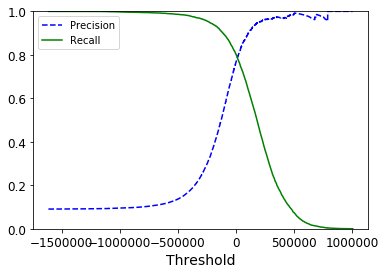

In [19]:
plot_precision_recall_vs_threshold(precisions,recalls, thresholds)
plt.show()

In [20]:
y_train_pred_90 = (y_scores>70000)
precision_score(y_train_5, y_train_pred_90)
recall_score(y_train_5, y_train_pred_90)

0.69931746910164172

In [21]:
precision_score()

TypeError: precision_score() missing 2 required positional arguments: 'y_true' and 'y_pred'

### The ROC Curve

In [23]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

In [25]:
fpr.shape

(3435,)

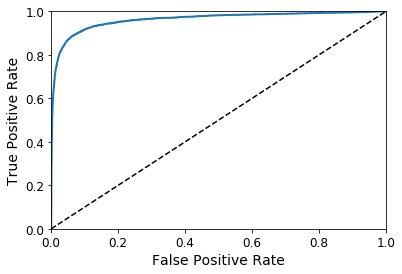

In [26]:
def plot_roc_curve(fpr, tpr, label = None):
    plt.plot(fpr, tpr, linewidth = 2, label = label)
    plt.plot([0,1],[0,1],'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_roc_curve(fpr, tpr)
plt.show()